In [1]:
from graph_of_words import GraphOfWords
import nltk
import numpy as np
import matplotlib.pyplot as plt
from torchtext.datasets import AG_NEWS
from torchdata.datapipes.iter import IterDataPipe
from nltk.stem import PorterStemmer
import torchtext
import torchdata
from collections import Counter
import re
import string
import networkx as nx
import copy
from collections import deque
from amplpy import AMPL
import cvxpy as cp
import cvxopt
import math
from sklearn.decomposition import PCA as sk_PCA

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Junkai
[nltk_data]     XIA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Junkai
[nltk_data]     XIA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
ps=PorterStemmer()

In [4]:
stopwords=nltk.corpus.stopwords.words('english')
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [5]:
train = AG_NEWS(split='train')
train_iter=iter(train)
def tokenize(line):
    res=[]
    raw=[ps.stem(w.lower()) for w in line.split() if (w.lower() not in stopwords and re.match(u'[a-z]', w, flags=re.I))]
    for item in raw:
        if "\\" in item:
            res+=[ps.stem(w.lower()) for w in item.split("\\")]
        else:
            res.append(item)
    return res

tokens = []
for label, line in train:
    tokens += tokenize(line)

In [6]:
cnt_tokens=Counter(tokens)
cnt_tokens.most_common()[:5]

[('new', 21118),
 ('said', 16855),
 ('us', 12148),
 ('first', 8956),
 ('two', 8882)]

In [7]:
def build_documents(size=10):
    docs=[]
    for i in range(size):
        docs.append(next(train_iter)[1])
    return docs

In [8]:
docs=build_documents(size=10)
docs

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.',
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.',
 'Oil prices soar to all-time record, posing new menace to US economy (A

In [9]:
def remove_iso(mat):
    dim=mat.shape[0]
    d=[]
    for z in range(dim):
        if mat[z,0]==np.inf:
            d.append(z)
    mat=np.delete(mat,d,axis=0)
    mat=np.delete(mat,d,axis=1)
    return mat

def dist2Gram(D):
    n = D.shape[0]
    J = np.identity(n) - (1.0/n)*np.ones((n,n))
    G = -0.5 * J@(D@(D@J))
    return G

def factor(A):
    n = A.shape[0]
    (evals,evecs) = np.linalg.eigh(A)
    evals[evals < 0] = 0 # closest SDP matrix
    X = evecs
    sqrootdiag = np.eye(n)
    for i in range(n):
        sqrootdiag[i,i] = np.sqrt(evals[i])
    X = X.dot(sqrootdiag)
    # because default eig order is small->large
    return np.fliplr(X)

def PCA(B,K):
    x = factor(B)
    # only first K columns
    x = x[:,0:K]
    return x

def Barvinok(B, K):
    n = B.shape[0]
    X = factor(B)
    y = (1/math.sqrt(K))*np.random.multivariate_normal(np.zeros(n*K), np.identity(n*K))
    y = np.reshape(y, (K, n))
    x = np.transpose(np.dot(y,X.T))
    return x

In [12]:
def writeRlz(graph, n , rlzfn):
    rlz = open(rlzfn, "w")
    print("param Kdim := 2;", file=rlz)
    print("param n := "+str(graph.number_of_nodes())+";", file=rlz)
    print("param : E : c I :=", file=rlz)
    for i in range(n):
        wi=list(graph.nodes)[i]
        for k in range(i+1,n):
            wk=list(graph.nodes)[k]
            if graph.has_edge(wi, wk):
                print(str(i+1) + " " + str(k+1) + " " + str(graph.get_edge_data(wi, wk)["weight"])+" "+str(1), file=rlz)
    print(";", file=rlz)
    rlz.close()
    return

def readDat(filename):
    edgeflag = False # true while reading edges
    Kdim = 3
    n = 0
    E = list()
    with open(filename) as f:
        for line in f:
            # look at file line by line
            line = line.strip()
            if len(line) > 0:       
                if line[0] != '#':
                    # line non-empty and non-comment
                    if edgeflag:
                        if line[0] == ';':
                            # if only a ';' then we're closing the edge section
                            edgeflag = False
                        else:
                            # reading uncommented edge data
                            cols = [c for c in line.split() if not '#' in c]
#                             print(cols)
                            if len(cols) >= 6:
                                e = (int(cols[0]), int(cols[1]), float(cols[4]), float(cols[5]))
                            elif len(cols) >= 4:
                                e = (int(cols[0]), int(cols[1]), float(cols[2]), float(cols[2]))
                                if e[2] > e[3]:
                                    print("readDat: WARNING: interval weight[", e[2], ",", e[3], "] empty, setting to", e[2])
                                    e[3] = e[2]
                            else:
                                print("readDat: ERROR: line", linecount, "has < 4 columns")
                                exit('abort')
                            E.append(e)
                    else:
                        if line.replace(" ","")[0:7] == 'param:E':
                            # we're in the edge section now
                            edgeflag = True
                        elif line.replace(" ","")[0:9] == 'paramKdim':
                            # parse line defining Kdim
                            Kdimstr = line.split()[3]
                            if Kdimstr[-1] == ';':
                                Kdimstr = Kdimstr[0:-1]
                            Kdim = int(Kdimstr)
                        elif line.replace(" ","")[0:6] == 'paramn':
                            # parse line defining n
                            nstr = line.split()[3]
                            if nstr[-1] == ';':
                                nstr = nstr[0:-1]
                            n = int(nstr)
    return (Kdim, n, E)

In [13]:
LPsolver = "cplex"
NLPsolver = "ipopt"
projmethod = "Barvinok"
# projmethod = "PCA"

In [68]:
class Graph_of_words():
    def __init__(self, documents):
        self.documents=documents     #D 【句子1，句子2，。。。】
        self.stopwords=nltk.corpus.stopwords.words('english')+[string.punctuation]
        self.token=[]
        self.tokens=[]               # token of the corresponding document
        self.dictionnary=[]          # T
        self.n=None                  # 文章单词数
        self.m=len(self.documents)   #一篇文章里有几句
        self.length=0                #最长的一句句子的顶点数
        self.graphs=[]               #每个句子对应一张图
        self.graph=None
        self.word_vec=[]
        self.coords=[]
        self.Kdim=None
        
        
        
    def preprocessing(self):
        for sentence in self.documents:
            t_temp=tokenize(sentence)
            self.tokens.append(t_temp)
            self.length+=len(t_temp)
            self.dictionnary+=[ps.stem(w.lower()) for w in sentence.split() if (w.lower() not in self.stopwords and re.match(u'[a-z]', w, flags=re.I))]
        
        self.dictionnary=list(set(self.dictionnary))
        self.n=len(self.dictionnary)
        self.idf=np.zeros((self.n,1))
        self.tw_idf=np.zeros((self.n,self.m))
#         self.metric=np.ones((len(self.dictionnary),len(self.dictionnary)))*np.inf
        self.metric=[]
    
    def update_graph_init(self,window, g):
        n=len(window)
        for i in range(n):
            for j in range(i+1,n):
                if not g.has_edge(window[i],window[j]):
                    g.add_edge(window[i],window[j],weight=1)
                else:
                    g[window[i]][window[j]]["weight"]+=1

    def update_graph(self,window,g):
        n=len(window)
        for i in range(n-1):
            if not g.has_edge(window[i],window[n-1]):
                g.add_edge(window[i],window[n-1],weight=1)
            else:
                g[window[i]][window[n-1]]["weight"]+=1

    def graph_construction(self, window_size=4):
        max_length=0
        for idx, doc in enumerate(self.documents):
            t_temp=self.tokens[idx]
            g_temp=nx.Graph()
            for t in self.dictionnary:
                if t in t_temp:
                    g_temp.add_node(t)
            
            if len(t_temp)<window_size:
                if weighted:
                    g_temp.add_edge(t_temp[0],t_temp[1],weight=1)
                else:
                    g_temp.add_edge(t_temp[0],t_temp[1])
            windows=t_temp[0:window_size]
            self.update_graph_init(windows, g_temp)
            for i in range(len(t_temp)-window_size):
                windows.pop(0)
                windows.append(t_temp[window_size+i])
                self.update_graph(windows, g_temp)
                
            self.graphs.append(g_temp)
            max_length=max(max_length,g_temp.number_of_nodes())
        self.length=max_length
#         self.graph=nx.DiGraph() if directed else nx.Graph()
#         for idx, doc in enumerate(self.documents):
#             t_temp=self.tokens[idx]
#             for t in self.dictionnary:
#                 if not t in self.graph.nodes:
#                     self.graph.add_node(t)
            
#             if len(t_temp)<window_size:
#                 if weighted:
#                     self.graph.add_edge(t_temp[0],t_temp[1],weight=1)
#                 else:
#                     self.graph.add_edge(t_temp[0],t_temp[1])
#             windows=t_temp[0:window_size]
#             Graph_of_words.update_graph_init(windows, self.graph ,weighted)
#             for i in range(len(t_temp)-window_size):
#                 windows.pop(0)
#                 windows.append(t_temp[window_size+i])
#                 Graph_of_words.update_graph(windows, self.graph ,weighted)
                
            
    def degree_centrality(node,g):
        if not node in gg.nodes:
            return 0
        neighbors=[i for i in nx.neighbors(g,node)]        
        return len(neighbors)/g.number_of_nodes()
    
    def term_weighting(self,b=0.003):
        for i in range(self.n):
            word=self.dictionnary[i]
            self.idf[i,0]=np.log((self.m+1)/len([d for d in self.documents if re.search(word, d, flags=re.I)]))
            
        for i in range(self.n):
            word=self.dictionnary[i]
            for j in range(self.m):
                token_temp=self.tokens[j]
                g_temp=self.graphs[j]
                cbt_temp=Counter(token_temp)
                tf=cbt_temp[word]
                self.tw_idf[i,j]=self.idf[i,0]*(Graph_of_words.degree_centrality(word,g_temp))/(1-b+b*len(token_temp)/(self.length/self.m))
    
    
    
    def write_dat(self):
#         for i in range(len(self.dictionnary)):
#             word_i=self.dictionnary[i]
#             self.metric[i,i]=0
#             for j in range(len(self.dictionnary)):
#                 word_j=self.dictionnary[j]
#                 if self.graph.has_edge(word_i,word_j):
#                     self.metric[i,j]=1/self.graph[word_i][word_j]["weight"]
        for i in range(self.m):
            graph=self.graphs[i]
            file_name="sentence_"+str(i)+".dat"
            writeRlz(graph, graph.number_of_nodes() , file_name)
            
    def _solve_dgp(self,idx,filename):
        self.Kdim, n, E = readDat(filename)
        g_temp=self.graphs[idx]
        K=g_temp.number_of_nodes()
        G = {i:dict() for i in range(n)}

        for e in E:
            i = e[0]-1 # first vertex
            j = e[1]-1 # second vertex
            w = e[2] # edge weight
            if i > j:
                t = i
                i = j
                j = t
            G[i][j] = w 
            
            
        X = cp.Variable((n,n), PSD=True)
        S = cp.Variable((n,n))
        cobj1 = sum([X[i,i] + X[j,j] - 2*X[i,j] for i in range(n) for j in G[i] if i<j])
        cobj2 = cp.trace(X)
#         R = 2*np.random.rand(n,n) - 1
#         cobj3 = cp.trace(R@X)
        cobj4=sum([S[i,j]**2 for i in range(n) for j in range(n)])
        cobj = cobj1 + 0.1*cobj2+cobj4 # + 0.1*cobj3
        
        objective = cp.Minimize(cobj)
        constraints = [X[i,i] + X[j,j] - 2*X[i,j] == G[i][j]**2+S[i,j] for i in range(n) for j in G[i] if i<j ]
        prob = cp.Problem(objective, constraints)    
        prob.solve(solver=cp.SCS, verbose=True)
        xbar = Barvinok(X.value, K)
        nlp = AMPL()
        nlp.read("dgp.mod")
        nlp.readData(filename)
        nlp.setOption('solver', NLPsolver)
        xvar = nlp.getVariable('x')
        print(xvar[0])
        for i in range(n):
            for k in range(K):
                xvar[i+1,k+1].setValue(xbar[i,k])
        nlp.solve()
        xvar = nlp.getVariable('x')
        xval = xvar.getValues()
        x = np.zeros((n,K))
        for i in range(n):
                for k in range(K):
                    x[i,k] = xvar[i+1,k+1].value()
        
        self.word_vec.append(x)
        
    def solve_dgp(self):
        for i in range(self.m):
            file_name="sentence_"+str(i)+".dat"
            self._solve_dgp(i, file_name)
    
    def _stacks(self,list_word_vec):
        avg=np.mean(list_word_vec,axis=0)
        if len(avg)>self.length:
            return avg[:self.length]
        else:
            return np.pad(avg,(0,self.length-len(avg)))
        
    def stack(self,k=2):
        total_vec=np.zeros((self.m,self.length))
        pca= sk_PCA(n_components=k)
    
        for i in range(self.m):
            sentence_vec=self._stacks(self.word_vec[i])
            total_vec[i]=sentence_vec
       
        
        self.coords=pca.fit_transform(total_vec)
            
                    
#     def complete(self):
#         dim=self.metric.shape[0]
#         for z in range(dim):
#             for u in range(dim):
#                 for v in range(dim):
#                     self.metric[u,v]=min(self.metric[u,v],self.metric[z,v]+self.metric[z,u])

#     def dim_reduction(self,n=2):
#         mat=remove_iso(self.metric)
#         gram=dist2Gram(mat)
#         new_coord_2=PCA(mat,2)
#         return new_coord_2
    
    

In [69]:
gg=nx.DiGraph()
gg.add_edge(0,1,weight=7)
gg[0][1]["weight"]+=1
gg.edges.data()
# gg.has_edge
# # help(gg.get_edge_data)
# # help(gg.add_edge)
# l=[0,1,2]
# l.pop(0)
# l.append(3)
# 0 in gg.nodes
# nx.distance_measures
gg.nodes(1)

NodeDataView({0: None, 1: None}, data=1)

In [70]:
G=Graph_of_words(docs)
G.preprocessing()
G.dictionnary[:5]
G.graph_construction()
G.write_dat()
G.solve_dgp()
G.stack()
# edges = [(u, v) for (u, v, d) in G.graph.edges(data=True) ]
# pos = nx.spring_layout(G.graph,seed=1) 
# for idx,(key,val) in enumerate(pos.items()):
#     pos[key]=new[idx]
# nx.draw_networkx_nodes(G.graph, pos, node_size=200)
# # nx.draw_networkx_edges(G.graphs[0], pos, edgelist=elarge, width=6)
# nx.draw_networkx_edges(
#     G.graph, pos, edgelist=edges, width=4, alpha=0.1, edge_color="b", style="dashed"
# )
# nx.draw_networkx_labels(G.graph, pos, font_size=6, font_family="sans-serif")

# ax = plt.gca()
# ax.margins(0.08)
# ax.figsize=(2,1)
# plt.axis("off")
# plt.tight_layout()
# plt.show()

# for g in G.graphs:
#     print(g.edges.data())
# G.graphs[0].edges.data()
# G.graphs[0].get_edge_data('band', 'wall')["weight"]
# list(G.graphs[0].nodes)

# G.word_vec[0]
# np.mean(G.word_vec[0],axis=0)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 14 02:57:55 PM: Your problem has 450 variables, 42 constraints, and 0 parameters.
(CVXPY) Feb 14 02:57:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 14 02:57:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 14 02:57:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 14 02:57:55 PM: Compiling problem (target solver=SCS).
(CVXPY) Feb 14 02:57:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

TypeError: Wrong number of indices used!

In [ ]:
G.coords

In [235]:
a=np.array([[ 3.31578414e-02, -3.45077932e-02, -1.04633496e-02],
 [ 5.35707692e-05, -1.65769231e-05,  5.73153846e-05],
 [ 4.09569695e-02, -1.04234114e-01,  9.39124513e-02],
 [-4.86714285e-05,  3.39404761e-05, -1.76619057e-06],
 [ 2.00302802e+01, -2.71614280e+00,  3.58562348e+01],
 [ 4.54208723e-06, -1.06916168e-06,  3.11041972e-06],
 [-7.18258705e-03, -2.53289808e-03, -1.11256275e-02],
 [ 1.03296296e-05,  3.33333333e-07, -1.32962963e-06],
 [-3.07728514e-06, -1.75675416e-05, -3.89490088e-05],
 [ 3.03755071e-02,  2.45274794e-02, -1.24835447e-02]])
pca= sk_PCA(n_components=2)
pca.fit_transform(a)
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : float or array-like, shape (n, )
        The data positions.
    
    s : float or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : array-like or list of colors or color, optional
        The marker colors. Possible values:
    
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
    
        Note that *c* should not be a single numeric RGB or RGBA sequence
    

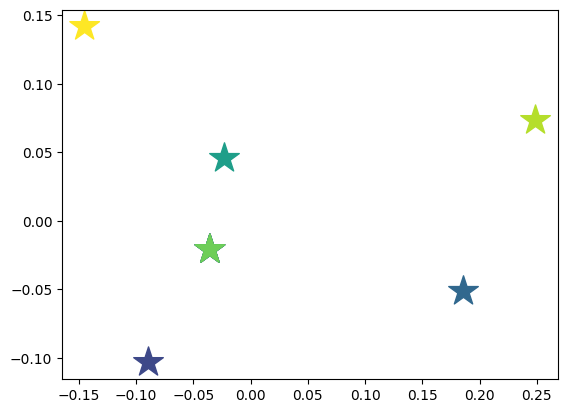

In [252]:
plt.figure()
plt.scatter(G.coords[:,0],G.coords[:,1],s=500,c=np.arange(len(G.coords)),marker="*")

plt.show()

In [ ]:
G.dictionnary[0]
G.dictionnary[11]

In [ ]:
graph = GraphOfWords(window_size=2)
graph.build_graph(
    docs,
    # OR a sentences list['Roses  are  red.', 'Violets are blue'],
    remove_stopwords=False,
    workers=4
)

graph.display_graph()